In [37]:
# mount the drive 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import os
os.chdir('./drive/MyDrive/NLP/Project/Turkish')
# !ls

FileNotFoundError: ignored

In [39]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import json
import os
from utilities.word_embeddings import WordEmbedding
from utilities.plots import *

### 1: Gender Bias in Word Embedding

### Data
January-December 2018 Commoncrawl
### Load data
Load the word embedding. The embedding maps each word into a 300-dimension vector. 

In [40]:
def load_professions():
    '''
       load data from profession.json 
    '''
    professions_file = os.path.join('./data', 'professions.json')
    with open(professions_file, 'r') as f:
        professions = json.load(f)
    # print('Loaded professions\n' +
    #       'Format:\n' +
    #       'word,\n' +
    #       'definitional female -1.0 -> definitional male 1.0\n' +
    #       'stereotypical female -1.0 -> stereotypical male 1.0')
    return professions

In [41]:
# load turkish Glove
E = WordEmbedding()
E.load_embeddings('./embeddings/turkish_vectors.txt')

# load professions
professions = load_professions()
profession_words = [p[0] for p in professions]

(253832, 300)


### 2: Define gender direction

We have used Woman - Man here to get the gender direction in the vector space.

In [42]:
v_gender = E.diff('kadını', 'adam')

### Corpus and vocab size is very large. Taking a subset of the vocab to calculate the score.

#### Generate analogies

In [43]:
a_gender = E.get_analogy_based_thresh(v_gender,max_words=30000)

Computing neighbors


In [44]:
she_occupation = ['homemaker', 'nurse', 'receptionist', 'librarian', 'socialite', 'hairdresser', 
'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'designer', 'sewing']

# she_occupation_turkish = []

### Normal install of googletrans didn't work, had to install alpha version.
https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group

In [45]:
#!pip install googletrans==3.1.0a0

In [46]:
from googletrans import Translator
translator = Translator()

### Helper Function to translate words from source language to target language

In [47]:
def get_translation(src_list,src_lang, tgt_lang):
  return [item.text for item in translator.translate(src_list, src=src_lang, dest=tgt_lang)]

  # for item in src_list:
  #   target = translator.translate(item, src=src_lang, dest=tgt_lang).text
  #   target_list.append(target)
  # return target_list

In [48]:
she_occupation_turkish = get_translation(she_occupation, 'en', 'tr')

In [49]:
for en, tr in zip(she_occupation, she_occupation_turkish):
  print(en, '\t\t\t', tr)

homemaker 			 ev hanımı
nurse 			 hemşire
receptionist 			 resepsiyonist
librarian 			 kütüphaneci
socialite 			 sosyetik
hairdresser 			 kuaför
nanny 			 dadı
bookkeeper 			 muhasebeci
stylist 			 stilist
housekeeper 			 kahya
designer 			 tasarımcı
sewing 			 dikiş


In [50]:
E.word2index['kadını']

3310

In [51]:
counter = 1
for (a,b,c) in a_gender:
    a,b = get_translation([a,b], 'tr', 'en')
    # if a in she_occupation_turkish:
    print(a+"-"+b+"-"+str(c))
    counter += 1 
    if counter > 50:
      break

woman-man-1.0
woman's-your man-0.72630006
to the woman-to the man-0.62636423
with woman-with the man-0.5674051
is a woman-is the man-0.5071459
from woman-from the man-0.48661
women-people-0.4651298
women-peoples-0.45814937
Hatice-Ali-0.44985628
lady-handsome-0.4485165
fatma-Hasan-0.44597846
older sister-brother-0.43073273
woman-gentleman-0.43001527
eminem-Ahmet-0.4250175
my cinema-tolga-0.41986892
daughter-son--0.4099087
our women-our youth-0.40680158
auntie-uncle-0.40375972
women-youth-0.40034848
my daughter-my son-0.40021813
wife-his father-0.39926654
to women-to children-0.39407244
betül-Hakan-0.39406663
from women-from people-0.3895776
to the lady-gentleman-0.38849005
lady-gentleman-0.38553262
Lady-Mr-0.37853307
with women-with people-0.37557966
woman-youth-0.3752285
you are right-huh-0.37075862
dear-mate-0.3707531
my partner-my father-0.3687628
actress-player-0.36851406
tugba-serdar-0.36611634
my older sister-my brother-0.36140114
ayse-Mehmet-0.3581946
ladies-guys-0.3567136
Esra-m

### Translate English profession words to Turkish

In [52]:
profession_words_turkish = get_translation(profession_words, 'en', 'tr')

In [53]:
profession_words_turkish[:10]

['Muhasebeci',
 'tanıdık',
 'aktör',
 'aktris',
 'yardımcı profesör',
 'yönetici',
 'maceracı',
 'avukat',
 'yardımcı',
 'meclis üyesi']

### Get embeddings, Handle exception for those words which are not part of the corpus

In [54]:
def get_embed(word):
  try:
    return E.embeddings[E.word2index[word]]
  except KeyError:
    return -1


### Check the gender bias

In [55]:
# sp = sorted([(E.get_embedding(w).dot(v_gender), w) for w in profession_words_turkish])
sp = []
counter = 0 
for word in profession_words_turkish:
  sim = get_embed(word)
  if isinstance(sim, int):
    # print('word not found: ', word)
    counter +=1 
  else:
    sp.append((sim.dot(v_gender), word))

sp = sorted(sp)
she_words = get_translation([item[1] for item in sp[-20:]], 'tr', 'en')
he_words = get_translation([item[1] for item in sp[0:20]], 'tr', 'en')

she_words1 = []
for item1, item2 in zip(she_words, sp[-20:]):
  she_words1.append((item2[0], item1))

he_words1 = []
for item1, item2 in zip(he_words, sp[0:20]):
  he_words1.append((item2[0], item1))



### Analysis of Gender Bias in Profession
* He professions are on the negative side of x-axis 
* She professions are on the positive side of x-axis

In [24]:
plot_words_extreme(he_words1, she_words1, 40, x_title='Word Extremes', y_title='Similarity', 
title='Gender Bias In Profession')

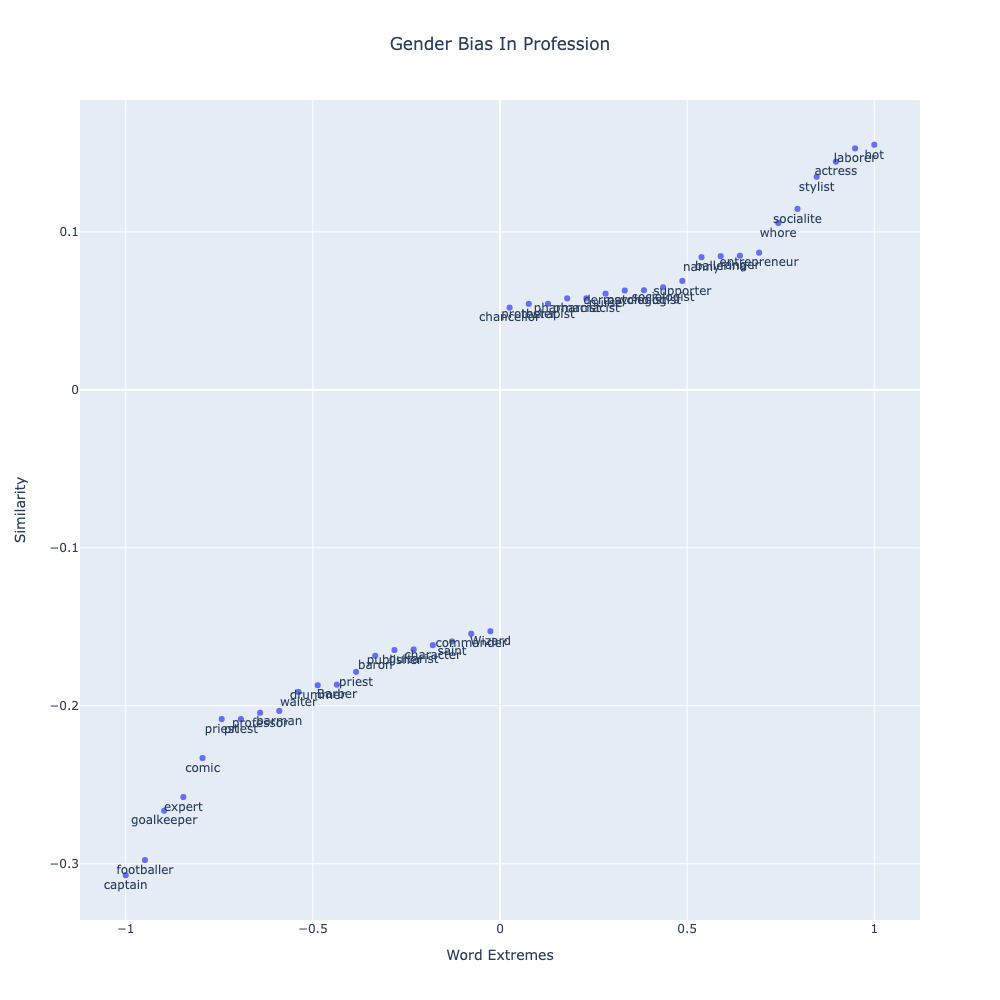

### Professions on Male side of the axis

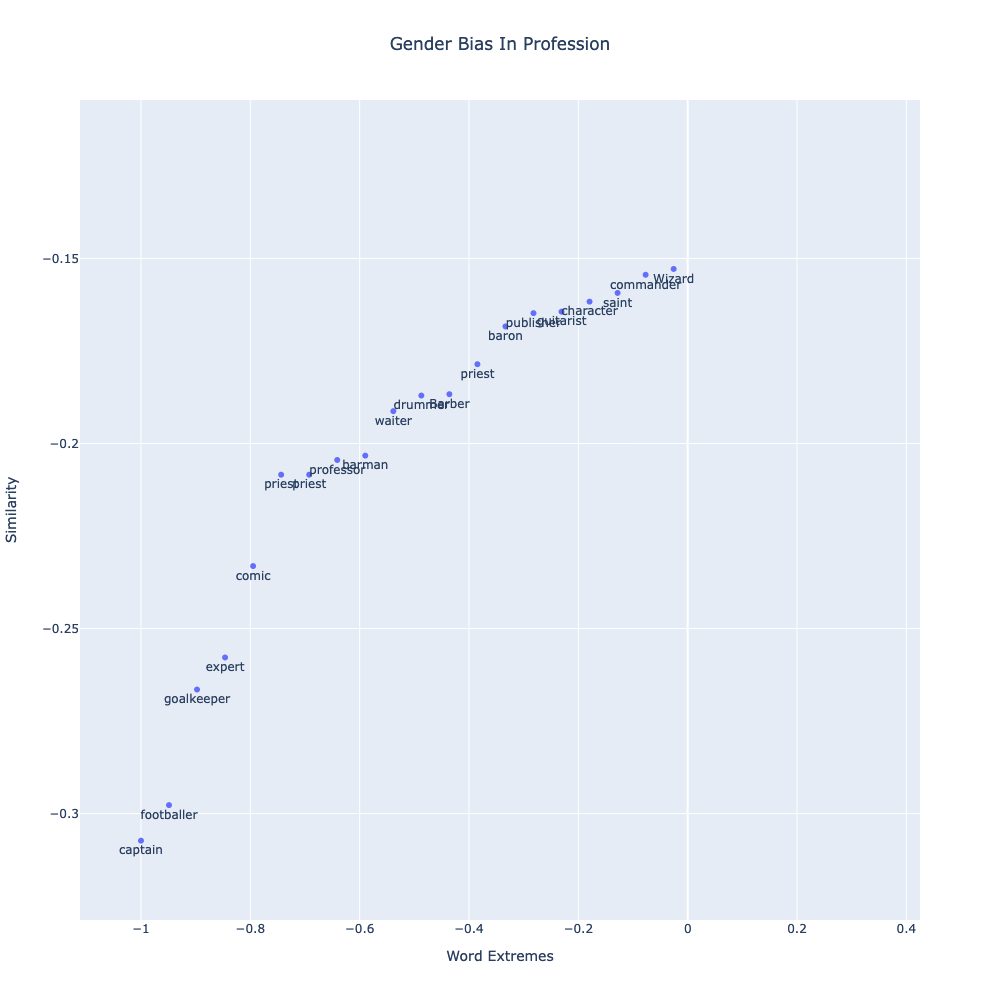

### Professions on Female side of the axis

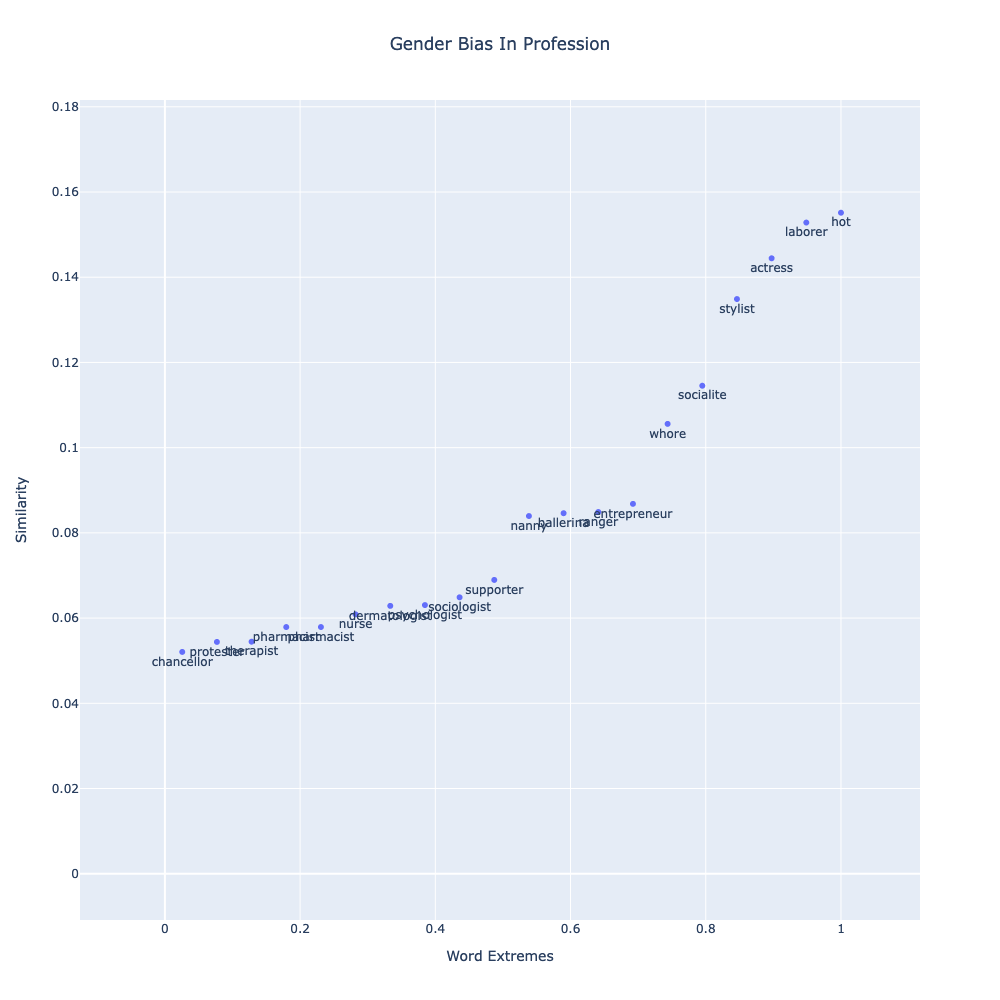

## Debiasing Algorithms
 
###Debiasing the gender bias from Turkish embeddings

####Step 1: - Identify the gender subspace

In this we are following the paper's implemented definitional pairs for Identifying the gender subspace in Turkish language after that PCA is used to reduce the dimensionality and to achieve the principal component. 

####Step 2 : - Hard de-biasing (neutralize and equalize)

Neutralize ensures that gender neutral words are zero in the gender subspace which we are getting by the help of "drop" function implemented below. 

Equalize is used to perfectly equalizes the sets of words which are outside the gender subspace and enforces that all the neurtral words are equidistant to the words in equality set, which is implemented in "debias_embeddings" function. 




In [25]:
from sklearn.decomposition import PCA

def find_direction(pairs, num_components = 10):
    '''
        Identify the gender subspace
    '''
    matrix = []
    counter = 0 
    for a, b in pairs:
        emb = get_embed(a) 
        if not isinstance(emb, int):
          center = (get_embed(a) + get_embed(b))/2
          matrix.append(get_embed(a) - center)
          matrix.append(get_embed(b) - center)
        else:
          counter += 1 
    
    print("Pairs dropped: ", len(pairs) - counter)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca


def drop(u, v):
    '''
        Align the words such that they are equidistant from 
        gender specific words
    '''
    return u - v * u.dot(v) / v.dot(v)

def debias_embeddings(E, gender_specific_words, definitional, equalize):
    '''
        Find gender direction and do hard debiasing.
    '''
    gender_direction = find_direction(definitional,num_components=12).components_[0]
    specific_set = set(gender_specific_words)
    for i, w in enumerate(E.words):
        if w not in specific_set:
            E.embeddings[i] = drop(E.embeddings[i], gender_direction)
            # Neutralize the gender neutral words in gender subspace
    E.normalize()
    candidates = {x for e1, e2 in equalize for x in [(e1.lower(), e2.lower()),
                                                     (e1.title(), e2.title()),
                                                     (e1.upper(), e2.upper())]}
    print(candidates)
    for (a, b) in candidates:
        if (a in E.word2index and b in E.word2index):
            y = drop((E.get_embedding(a) + E.get_embedding(b)) / 2, gender_direction)
            z = np.sqrt(1 - np.linalg.norm(y)**2)
            if (E.get_embedding(a) - E.get_embedding(b)).dot(gender_direction) < 0:
                z = -z
            E.embeddings[E.word2index[a]] = z * gender_direction + y
            E.embeddings[E.word2index[b]] = -z * gender_direction + y
    E.normalize()
    # visualization of the turkish embeddings after debiasing algorithms
    candidates_tr = []
    mdict = dict(candidates)
    resultList = [[key, value] for key, value in mdict.items()]
    for item in resultList:
        candidates_tr.append(get_translation(item, 'tr', 'en'))
    print("In English--> ", candidates_tr)
    


### Translate Definitional, Equalize and Gender Specific words in Turkish Language

Here Google Translator is used to translate Definitional, Equalize and Gender Specific words in Turkish Language in order to make the embeddings available to the debiasing algorithms

In [26]:
# words used to identify the gender subspace
with open('./data/definitional_pairs.json', "r") as f:
    defs = json.load(f)
# print(len(defs), defs)
# words used to identify the gender subspace in turkish
defs_tr = []
for item in defs:
     defs_tr.append(get_translation(item, 'en', 'tr'))
print("Definitional ->", defs_tr)

##Equalize and Neutralize
# Equalize pairs ensure that neutral words are equidistant from both extremes 
with open('./data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)
# print(equalize_pairs)
# Equalize pairs ensure that neutral words are equidistant from both extremes 
# in Turkish
equalize_pairs_tr = []
for item in equalize_pairs:
     equalize_pairs_tr.append(get_translation(item, 'en', 'tr'))
print("Equalized Pairs ->",equalize_pairs_tr)



# words where gender specificity is desired
with open('./data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)
# print("gender specific", len(gender_specific_words), gender_specific_words[:10])
# words where gender specificity is desired in turskish 
gender_specific_words_tr = []
gender_specific_words_tr = get_translation(gender_specific_words, 'en', 'tr')
print("Gender specific in turkish", gender_specific_words_tr[:10])

Definitional -> [['Kadın', 'adam'], ['kız', 'oğlan'], ['o', 'o'], ['anne', 'baba'], ['kız evlat', 'oğul'], ['gal', 'insan'], ['dişi', 'erkek'], ['o', 'onun'], ['kendini', 'kendisi'], ['Mary', 'John']]
Equalized Pairs -> [['manastır', 'manastır'], ['sözcü', 'sözcü'], ['Katolik_rahip', 'rahibe'], ['Baba', 'Anne'], ['Erkekler', 'Kadın'], ['meclis üyesi', 'meclis üyesi'], ['büyükbaba', 'büyükanne'], ['torunlar', 'torunlar'], ['prostat kanseri', 'Yumurtalık kanseri'], ['testosteron', 'estrojen'], ['amca dayı', 'hala'], ['eşler', 'kocalar'], ['Baba', 'Anne'], ['büyükbaba', 'büyükanne'], ['O', 'O'], ['oğlan', 'kız'], ['erkek çocuklar', 'kızlar'], ['Erkek kardeş', 'kardeş'], ['Kardeşler', 'kız kardeşler'], ['işadamı', 'iş kadını'], ['başkan', 'başkan'], ['tay', 'kısrak'], ['kongre üyesi', 'kongre üyesi'], ['baba', 'anne'], ['babalar', 'anneler'], ['ahbaplar', 'kızlar'], ['eski kız arkadaşı', 'eski erkek arkadaş'], ['baba', 'anne'], ['babalık', 'annelik'], ['babalar', 'anneler'], ['dostum', 'bü

In [27]:
debias_embeddings(E, gender_specific_words_tr, defs_tr, equalize_pairs_tr)

Pairs dropped:  7
{('krallar', 'kraliçeler'), ('Işadamı', 'Iş Kadını'), ('beyefendi', 'hanım'), ('ADAM', 'KADIN'), ('Kral', 'Kraliçe'), ('KATOLIK_RAHIP', 'RAHIBE'), ('Oğul', 'Kız Evlat'), ('IĞDIŞ EDILMIŞ', 'KISRAK'), ('Erkekler', 'Kadın'), ('Erkek', 'Dişi'), ('Prostat Kanseri', 'Yumurtalık Kanseri'), ('TESTOSTERON', 'ESTROJEN'), ('AHBAPLAR', 'KIZLAR'), ('baba', 'anne'), ('oğul', 'kız evlat'), ('PRENS', 'PRENSES'), ('Manastır', 'Manastır'), ('TORUNLAR', 'TORUNLAR'), ('işadamı', 'iş kadını'), ('babalar', 'anneler'), ('ESKI KIZ ARKADAŞI', 'ESKI ERKEK ARKADAŞ'), ('Ahbaplar', 'Kızlar'), ('DOSTUM', 'BÜYÜKANNE'), ('BEYLER', 'HANIMLAR'), ('Kongre Üyesi', 'Kongre Üyesi'), ('ikiz kardeş', 'ikiz kardeş'), ('Erkek Çocuklar', 'Kızlar'), ('büyük baba', 'nene'), ('Iğdiş Edilmiş', 'Kısrak'), ('OĞLAN', 'KIZ'), ('kardeşlik', 'kız öğrenci yurdu'), ('katolik_rahip', 'rahibe'), ('erkek torun', 'kız torun'), ('ERKEK ÇOCUKLAR', 'KIZLAR'), ('MANASTIR', 'MANASTIR'), ('erkek', 'dişi'), ('prens', 'prenses'), ('o

#### Check the gender bias




In [28]:
sp_debiased = []

for word in profession_words_turkish:
  sim = get_embed(word)
  if not isinstance(sim, int):
    sp_debiased.append((sim.dot(v_gender), word))

sp_debiased = sorted(sp_debiased)

In [29]:
she_words = get_translation([item[1] for item in sp_debiased[0:20]], 'tr', 'en')
he_words = get_translation([item[1] for item in sp_debiased[-20:]], 'tr', 'en')

she_words1 = []
for item1, item2 in zip(she_words, sp_debiased[0:20]):
  she_words1.append((item2[0], item1))

he_words1 = []
for item1, item2 in zip(he_words, sp_debiased[-20:]):
  he_words1.append((item2[0], item1))

### Plots for Gender Debiased Algorithms

Google Translator is used to convert turkish words back to english (for representation purposes)

In [36]:
plot_words_extreme(she_words1, he_words1, 40, x_title='Word Extremes', y_title='Similarity', 
title='Gender Debias In Profession')

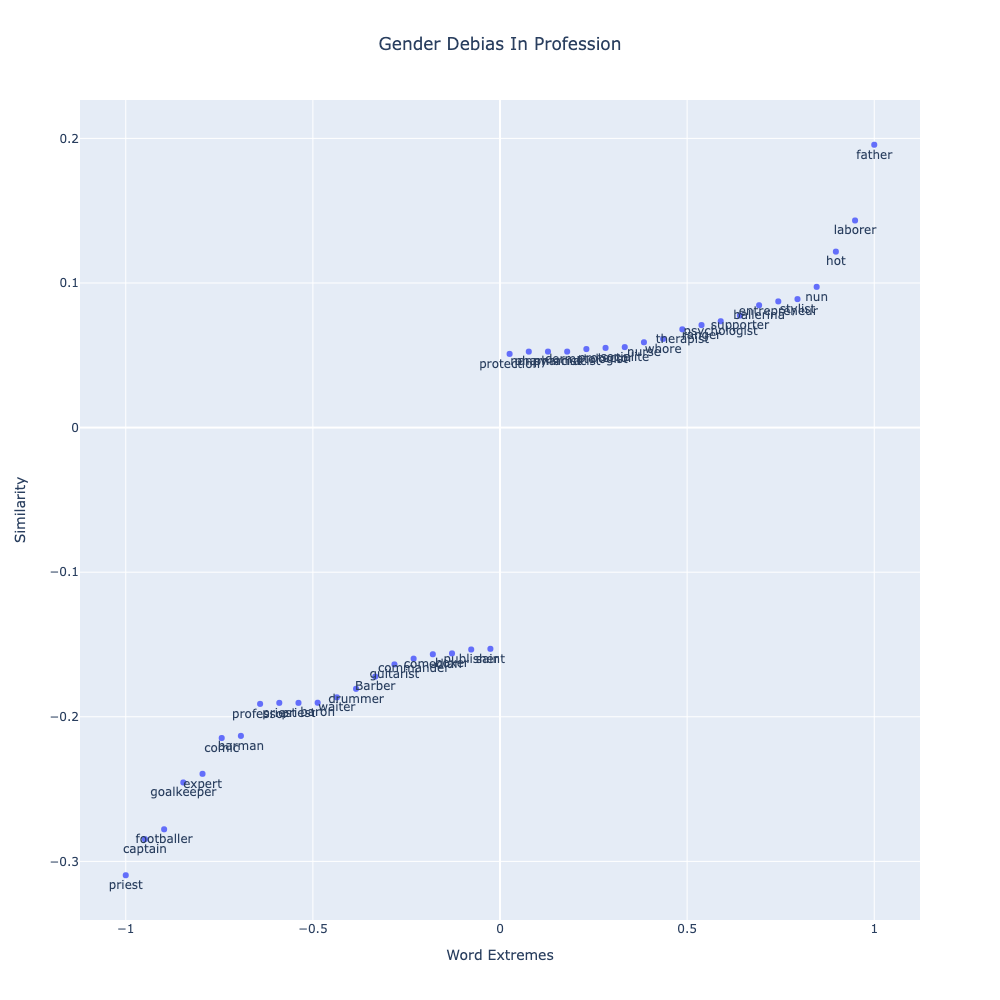

#### Zoomed In - Female Quadrant

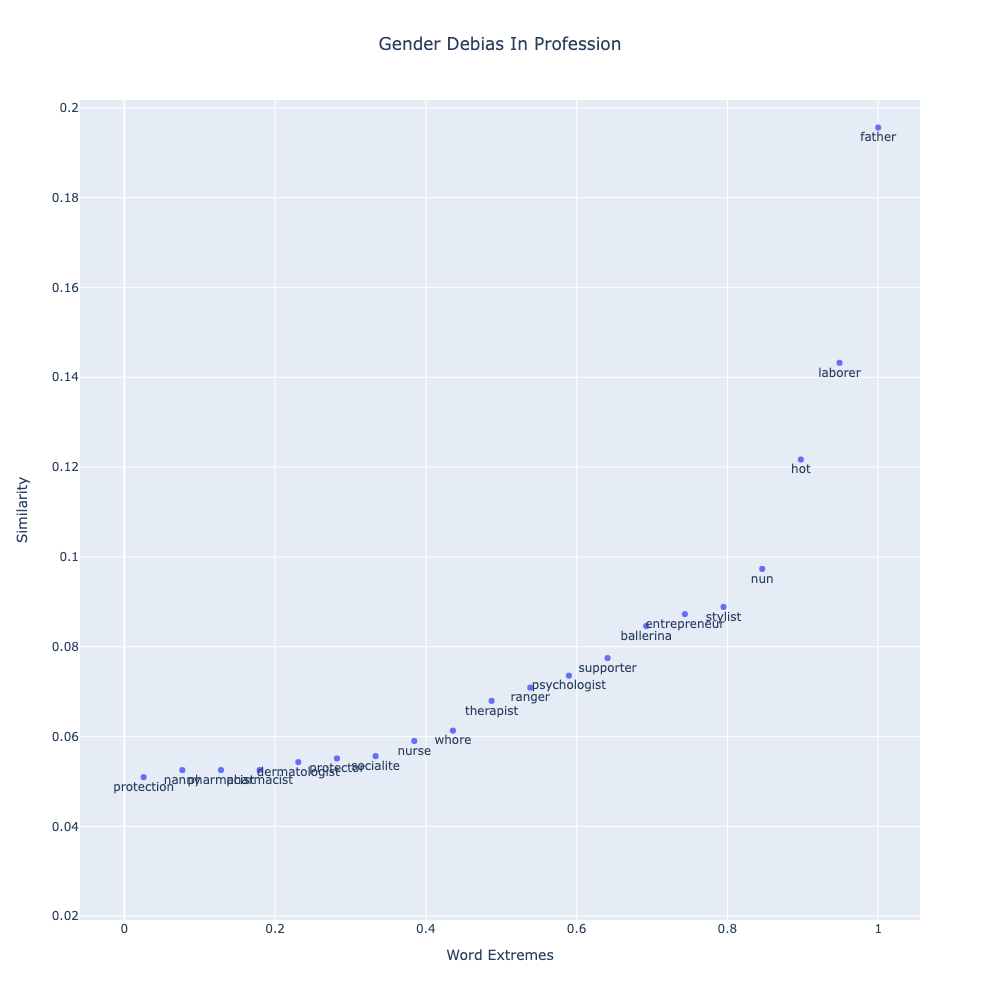

### Zoomed In - Male Quadrant

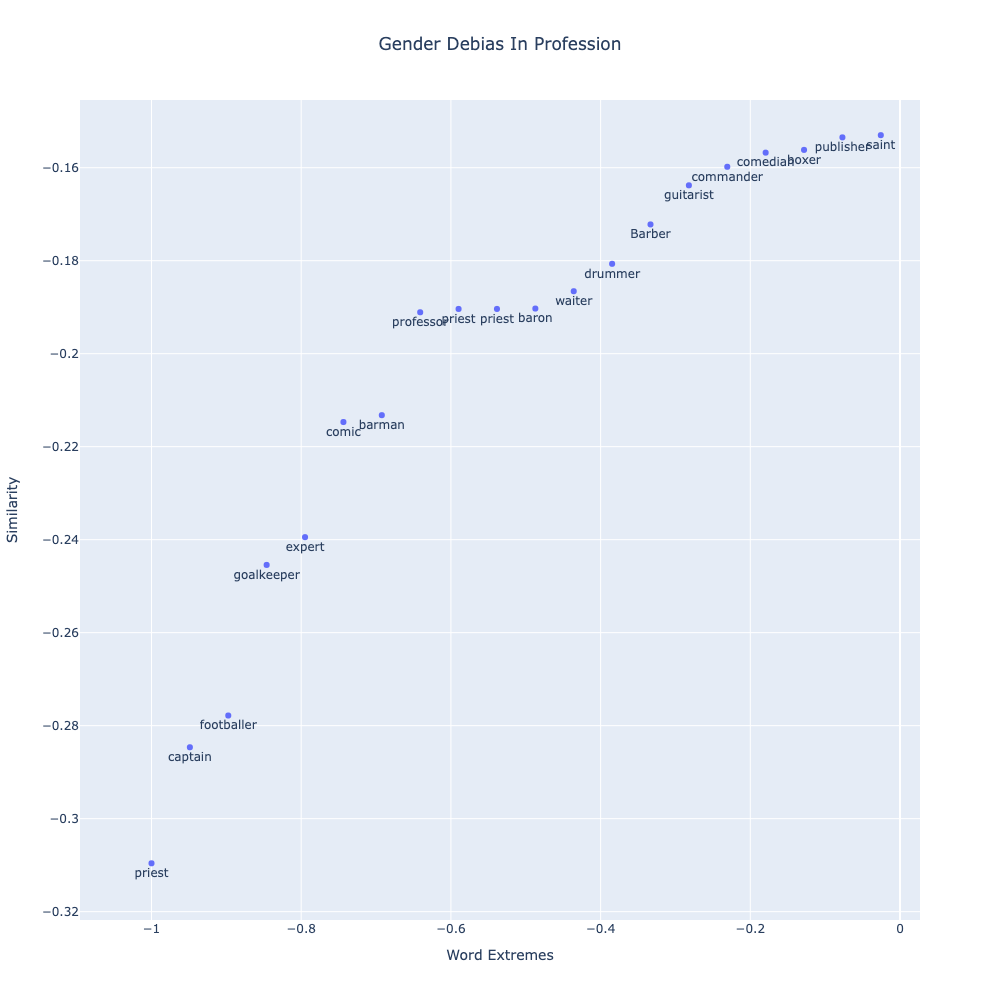

### Obeservations 

We can see that the debiasing method is somewhat effective here. We have also observed that the google translation is quite literal so we tried getting the translation for Definitional, Equalize and Gender Specific words from Lingvanex which seems to give better translation for turkish words. 


### Translate Definitional, Equalize and Gender Specific words in Turkish Language using Lingvanex

Here Lingvanex Translator is used to translate Definitional, Equalize and Gender Specific words in Turkish Language in order to make the embeddings available to the debiasing algorithms. We choose this translator as an alternative to google's translator, also recommended by google on top results.

We manually translated Definitional, Equalize and Gender specific words.

Link:- https://lingvanex.com/demo/

In [31]:
# words used to identify the gender subspace
with open('./data/definitional_pairs_turkish.json', "r") as f:
    defs = json.load(f)
print(len(defs), defs)

# Equalize pairs ensure that neutral words are equidistant from both extremes 
with open('./data/equalize_pairs_turkish.json', "r") as f:
    equalize_pairs = json.load(f)
print(equalize_pairs)

# words where gender specificity is desired
with open('./data/gender_specific_seed_turkish.json', "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

7 [['kadını', 'adam'], ['kız', 'oğlan'], ['anne', 'baba'], ['kızı', 'oğul'], ['kadını', 'erkek'], ['onu', 'onun'], ['Maryam', 'Yahya']]
[['sözcü', 'sözcüsü'], ['rahip', 'rahibe'], ['Baba', 'Anne'], ['Erkekler', 'kadını'], ['meclis üyesi', 'meclis üyesi'], ['dede', 'büyükanne'], ['prostat kanseri', 'yumurtalık kanseri'], ['testosteron', 'östrojen'], ['amca', 'teyze'], ['eşleri', 'kocalar'], ['Büyükbaba', 'Büyükanne'], ['oğlan', 'kız'], ['çocuklar', 'kızlar'], ['kardeş', 'kız kardeş'], ['kardeşler', 'kız kardeşler'], ['işadamı', 'iş kadını'], ['colt', 'kısrak'], ['dostlar', 'gals'], ['babalık', 'annelik'], ['babalar', 'anneler'], ['dostum', 'büyükanne'], ['beyefendi', 'bayan'], ['beyler', 'bayanlar'], ['dede', 'büyükanne'], ['onun', 'onu'], ['kral', 'kraliçe'], ['krallar', 'kraliçeler'], ['erkek', 'kadını'], ['erkekler', 'dişiler'], ['adam', 'kadını'], ['erkekler', 'kadınlar'], ['yeğen', 'yeğen'], ['prens', 'prenses'], ['okul çocuğu', 'kız öğrenci'], ['oğul', 'kızı'], ['oğulları', 'kızla

In [32]:
debias_embeddings(E, gender_specific_words, defs, equalize_pairs)

Pairs dropped:  6
{('AMCA', 'TEYZE'), ('krallar', 'kraliçeler'), ('Işadamı', 'Iş Kadını'), ('EŞLERI', 'KOCALAR'), ('SÖZCÜ', 'SÖZCÜSÜ'), ('Dostlar', 'Gals'), ('Kral', 'Kraliçe'), ('Adam', 'Kadını'), ('Prostat Kanseri', 'Yumurtalık Kanseri'), ('onun', 'onu'), ('baba', 'anne'), ('PRENS', 'PRENSES'), ('kardeş', 'kız kardeş'), ('Yeğen', 'Yeğen'), ('sözcü', 'sözcüsü'), ('işadamı', 'iş kadını'), ('Beyefendi', 'Bayan'), ('babalar', 'anneler'), ('DOSTUM', 'BÜYÜKANNE'), ('OĞUL', 'KIZI'), ('oğulları', 'kızları'), ('ERKEKLER', 'KADINLAR'), ('OĞLAN', 'KIZ'), ('prens', 'prenses'), ('KARDEŞ', 'KIZ KARDEŞ'), ('RAHIP', 'RAHIBE'), ('OĞULLARI', 'KIZLARI'), ('ADAM', 'KADINI'), ('Erkekler', 'Kadını'), ('erkek', 'kadını'), ('erkekler', 'dişiler'), ('KARDEŞLER', 'KIZ KARDEŞLER'), ('ONUN', 'ONU'), ('eşleri', 'kocalar'), ('Kardeş', 'Kız Kardeş'), ('ERKEK', 'KADINI'), ('Büyükbaba', 'Büyükanne'), ('BÜYÜKBABA', 'BÜYÜKANNE'), ('Krallar', 'Kraliçeler'), ('Sözcü', 'Sözcüsü'), ('TESTOSTERON', 'ÖSTROJEN'), ('Oğlan', '

#### Check the gender bias

In [33]:
sp_debiased = []

for word in profession_words_turkish:
  sim = get_embed(word)
  if not isinstance(sim, int):
    sp_debiased.append((sim.dot(v_gender), word))

sp_debiased = sorted(sp_debiased)

she_words = get_translation([item[1] for item in sp_debiased[0:20]], 'tr', 'en')
he_words = get_translation([item[1] for item in sp_debiased[-20:]], 'tr', 'en')

she_words1 = []
for item1, item2 in zip(she_words, sp_debiased[0:20]):
  she_words1.append((item2[0], item1))

he_words1 = []
for item1, item2 in zip(he_words, sp_debiased[-20:]):
  he_words1.append((item2[0], item1))

### Plots for Gender Debiased Algorithms


In [35]:
plot_words_extreme(she_words1, he_words1, 40, x_title='Word Extremes', y_title='Similarity', 
title='Gender Debias In Profession')

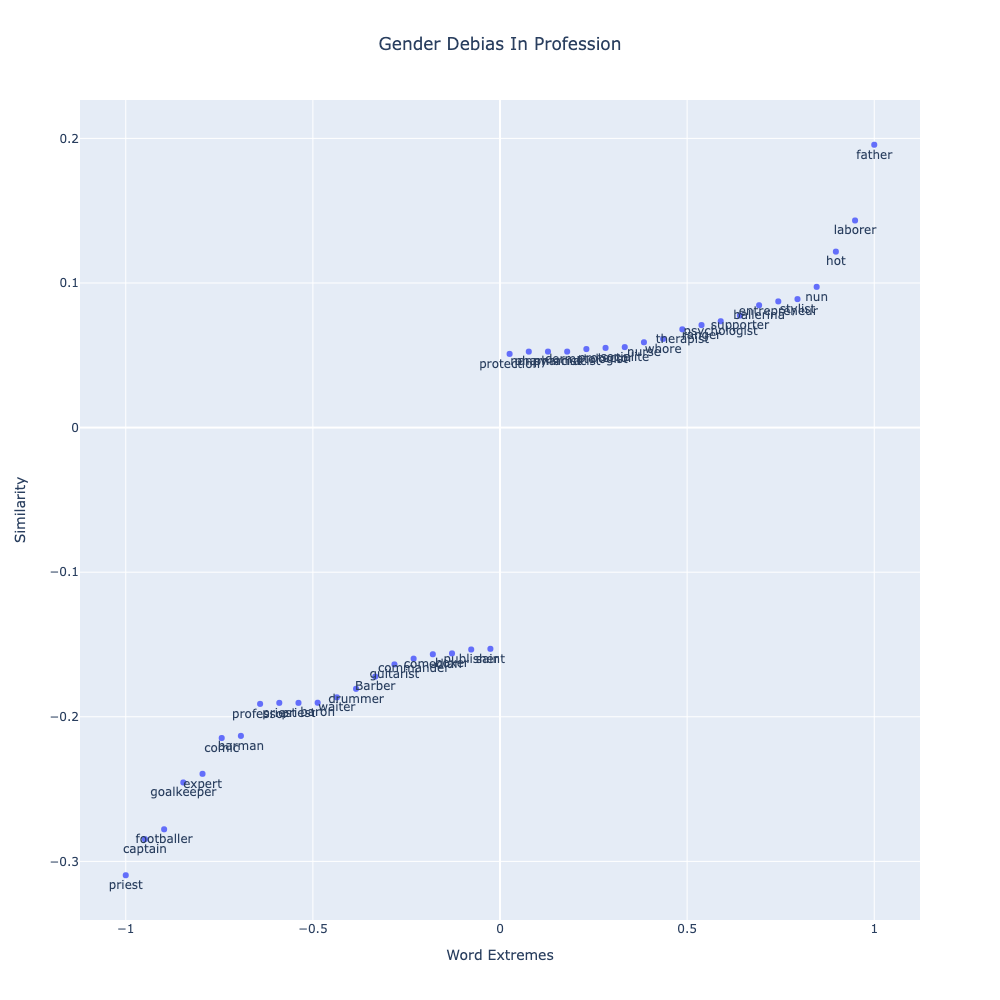

#### Zoomed In - Female Quadrant

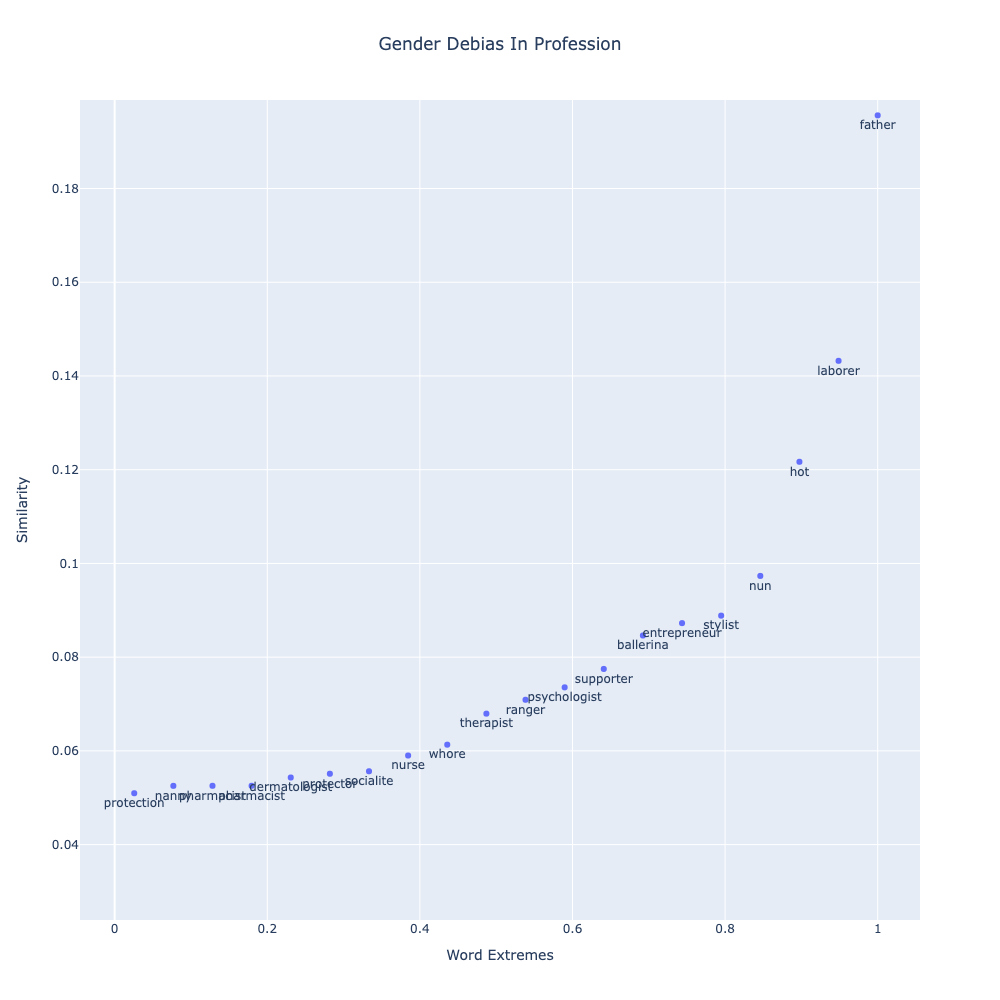

#### Zoomed In - Male Quadrant
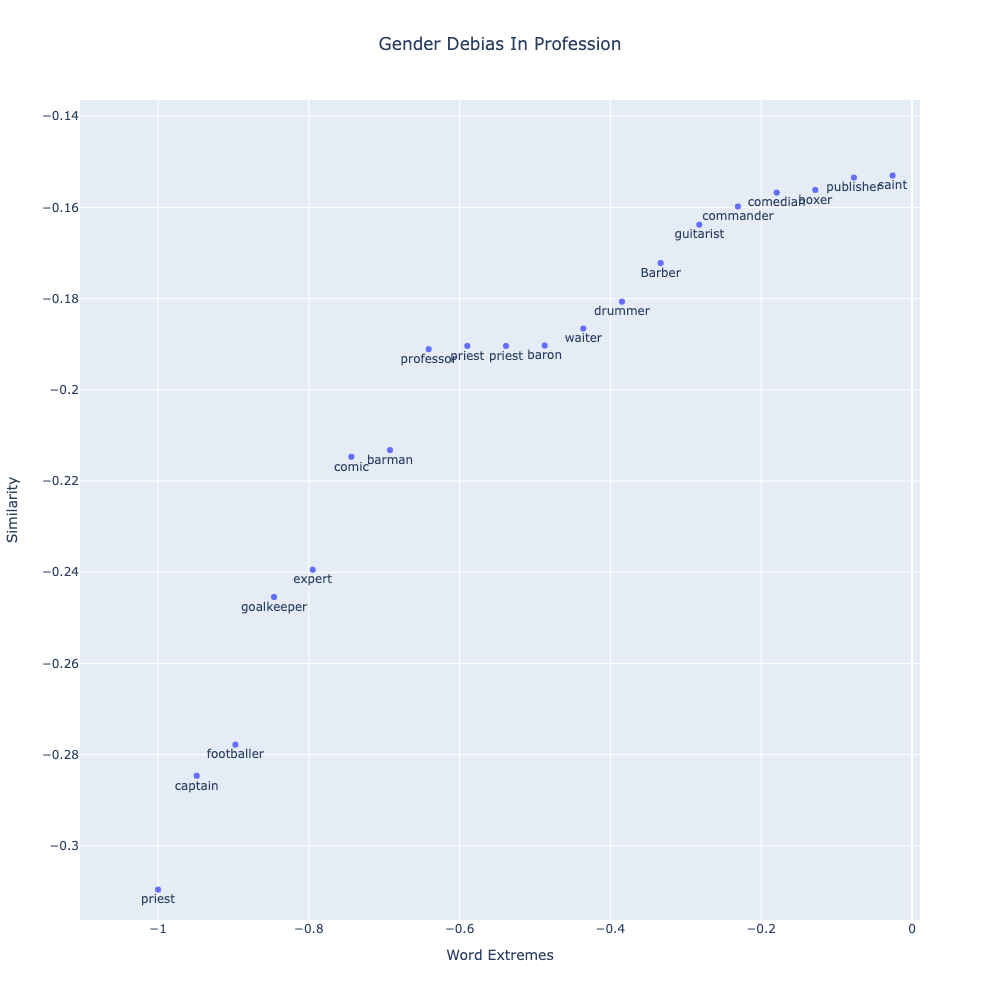

### Observation and Conclusion

After using other translator we are able to debias the gender but not upto the mark so we observe that the debiasing algorithms mentioned in the paper does not perform well on Turkish embeddings.
